<br> 

### Imports & Config

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

# silence warnings
warnings.filterwarnings('ignore')

<br>


### Initial Read & Clean

<br><br>

<table class="customTable" style="width: 60%; height: 20%; background-color: #FFFFFF; border-width: 3px; border-color: #10151F; border-style: solid; color: #000000;">
  <thead style="background-color: #EDD9C7;">
    <tr>
      <th>Feature Name</th>
      <th>Kind of Data</th>
    </tr>
  </thead>
  <tbody style="border-width: 3px; border-color: #10151F; border-style: solid; padding: 5px;">
    <tr>
      <td>mpg</td>
      <td>continuous</td>
    </tr>
    <tr>
      <td>cylinders</td>
      <td>categorical</td>
    </tr>
    <tr>
      <td>displacement</td>
      <td>continuous</td>
    </tr>
    <tr>
      <td>horsepower</td>
      <td>continuous</td>
    </tr>
    <tr>
      <td>weight</td>
      <td>continuous</td>
    </tr>
    <tr>
      <td>acceleration</td>
      <td>continuous</td>
    </tr>
    <tr>
      <td>model_year</td>
      <td>categorical</td>
    </tr>
    <tr>
      <td>origin</td>
      <td>categorical</td>
    </tr>
    <tr>
      <td>car_name</td>
      <td>categorical (unique string id)</td>
    </tr>
  </tbody>
</table>

<br><br>

In [2]:
# get the data from location of raw data in repo
df = pd.read_csv("https://raw.githubusercontent.com/pekkalacd/auto_mpg/main/auto_mpg.csv")

In [3]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [4]:
# count all NaN per column
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

In [5]:
# check dtype of horsepower
df['horsepower'].dtype

dtype('float64')

In [6]:
# per index horsepower is continuous, take mean of other values
hp_mu = df['horsepower'].mean()
df['horsepower'].fillna(hp_mu,inplace=True)

In [7]:
# count all NaN per column again
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

<br>

### Exploratory Data Analysis

In [8]:
# show descriptive statistics
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.199187,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [9]:
# find distinct values per feature
df.nunique()

mpg             129
cylinders         5
displacement     82
horsepower       94
weight          351
acceleration     95
model_year       13
origin            3
car_name        305
dtype: int64

In [10]:
# look @ dtypes of features
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

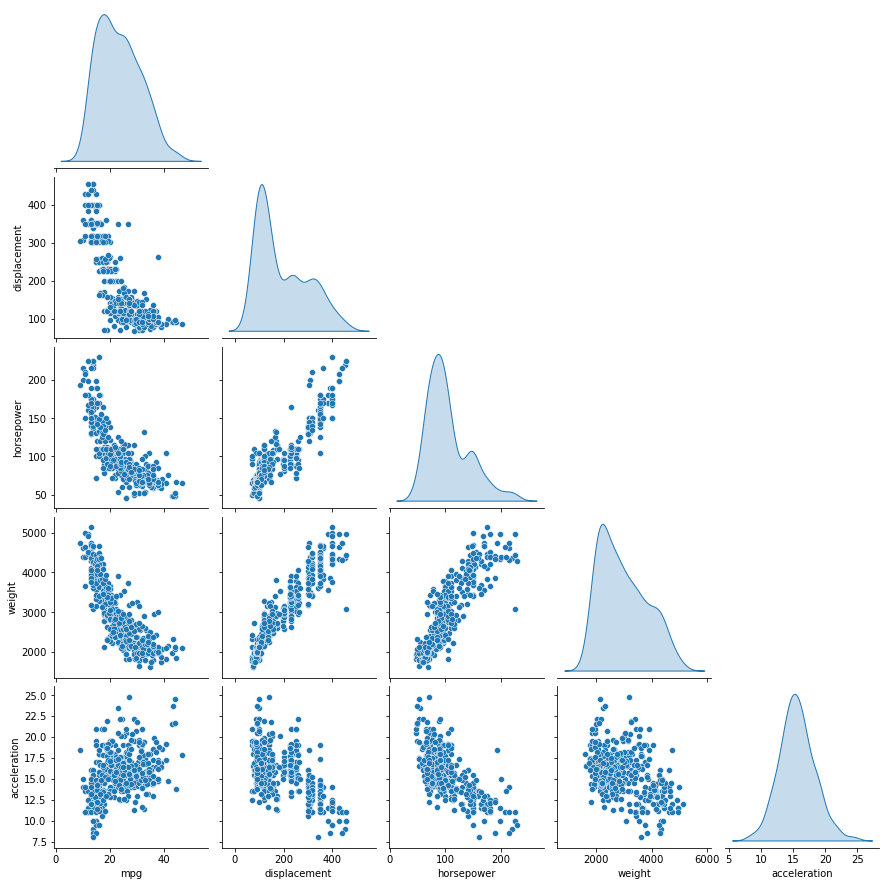

In [11]:
# look @ pairplot to see if data fits normal distribution ~ ignoring categorical ["origin","model_year","cylinders","car_name"]
continuous = df.select_dtypes(include=[np.float64])
_=sns.pairplot(continuous,
                diag_kind="kde",
                corner=True)

<br>

### Test of Normality
<p style="font-size:16px;">
It appears acceleration follows a normal distribution but we would want to be positive. The other features' density curves appear to skew to the left and have different shapes. We would like to be sure, because eventually once we construct our model, we'll need to scale our continuous features.
</p>
<p style="font-size:16px;">
    Since there are not many observations in this dataset, we will use the <b>Shapiro-Wilk</b> test. This requires that a random sample of a feature's values are selected. Because it is a sample, we'll select roughly 150 values to test without replacement. Ultimately, this will determine if the data in each continuous feature follows a normal distribution. <br>
</p>
<p style="font-size:16px;">
Shapiro-Wilk involves a null-hypothesis: the data is normally distributed. If we fail to reject the null hypothesis, pvalue > 0.05, then the feature is normally distributed. If we are able to reject the null hypothesis, however, then pvalue < 0.05, the feature is not normally distributed. 
</p>

In [12]:
np.random.seed(111)
for col in continuous:
    s = np.random.choice(continuous[col],150,replace=False)
    shapiro = scipy.stats.shapiro(s)
    p = shapiro.pvalue
    if p < 0.05:
        print(f"{col} is not normally distributed")
    else:
        print(f"{col} is normally distributed")

mpg is not normally distributed
displacement is not normally distributed
horsepower is not normally distributed
weight is not normally distributed
acceleration is normally distributed


<br>
<p style="font-size:16px;">
<br><br>
Regression tasks usually require that the distribution of values have a mean of 0 and standard deviation of 1. We can use the <b>StandardScaler</b> from sklearn to help put our continuous values in this form, after train-test-split.
</p>
<br> 

<br>

### Train-Test-Split  (SGD)

<br>

In [13]:
# we will need this twice - so i will separate our predictors from the target [mpg]
X = df.drop(columns=['car_name','mpg'],axis=1)
y = df['mpg']

In [14]:
# we'll start w/stochastic gradient descent regressor
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=25)
reg = Pipeline([('preprocess',StandardScaler()), ('sgd',SGDRegressor(random_state=102))])
reg.fit(X_train,y_train)

Pipeline(steps=[('preprocess', StandardScaler()),
                ('sgd', SGDRegressor(random_state=102))])

In [15]:
# make prediction on test
reg.score(X_test,y_test)

0.8117245221814873

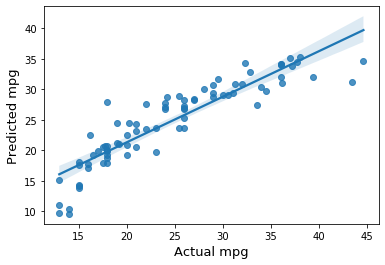

In [16]:
# regression plot y-pred vs y-actual (test)
res=pd.DataFrame()
res['prediction']=reg.predict(X_test)
res['actual']=y_test.values
ax=sns.regplot(data=res,x="actual",y="prediction")
ax.set_xlabel("Actual mpg",fontsize=13)
ax.set_ylabel("Predicted mpg",fontsize=13)
plt.show()

<br>

<p style="font-size: 16px;">
    So, by the looks of it with a barebones configuration of SGDRegressor, after standardizing our train data, we got an accuracy score of roughly <b>81%</b>. <br><br>
</p>
<p style="font-size: 16px;">
The <b>train_test_split</b> worked like so: 80% of the dataset was reserved to "train" our model and randomly sampled. While only 20% of the data was sampled for testing our model. The SGDRegressor used the 80% to recognize patterns between the predictors (X_train) and the target (y_train). From there, once the guessing strategy was determined, the model saw  the remaining 20% of predictor values (X_test) and made a prediction vector for what the target test data (y_test) contained. Finally, an accuracy score was determined, a simple ratio between the model's predictions and the actual y_test data. And it found nearly 81% of its guesses were correct!
</p>   
<br>
<p style="font-size: 16px;">
Now let's tune our hyperparameters for the SGDRegressor via <b>GridSearchCV</b> to see if that improves things.
<br><br>

In [17]:
# tune loss & penalty & learning rate
params={'sgd__loss':['squared_error','huber','epsilon_insensitive'],
        'sgd__penalty': ['l2','l1','elasticnet'],
        'sgd__learning_rate': ['constant','optimal','invscaling','adaptive']}

# create gridsearch classifier for sgdregressor pipeline above (reg) 
# w/params to tune ~ scoring 'accuracy' & 5-fold cross validation
clf=GridSearchCV(reg,params,cv=5)

# fit to our training data
clf.fit(X_train,y_train)

# see the 'best' hyperparameter config according to accuracy
clf.best_params_

{'sgd__learning_rate': 'adaptive',
 'sgd__loss': 'squared_error',
 'sgd__penalty': 'l2'}

<br>

<p style="font-size: 16px;">
GridSearchCV was performed above. This algorithm essentially performs a pair-wise, all possible combinations comparison between the hyperparameter key-value pairs in the "params" dictionary, and continually trains and tests the model on each combination, maximizing the scoring function. The .best_params_ attribute returns a key-value pairing for each model hyperparameter which yields the highest score.
</p>
<br>
<p style="font-size: 16px;">
We will now use this hyperparameter configuration in our SGDRegressor and see if the accuracy score is higher.
</p>

In [18]:
# we'll do our w/stochastic gradient descent regressor again, now with the gridsearch best parameters
best_params = {k.replace('sgd__',''):v for k,v in clf.best_params_.items()}
reg = Pipeline([('preprocess',StandardScaler()), ('sgd',SGDRegressor(**best_params,random_state=101))])
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

0.8158809015472985

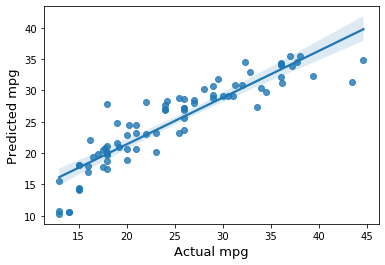

In [19]:
# regression plot y-pred vs y-actual (test)
res=pd.DataFrame()
res['prediction']=reg.predict(X_test)
res['actual']=y_test.values
ax=sns.regplot(data=res,x="actual",y="prediction")
ax.set_xlabel("Actual mpg",fontsize=13)
ax.set_ylabel("Predicted mpg",fontsize=13)
plt.show()

<br>
<p style="font-size: 16px;">
GridSearchCV in this case did not drastically raise the score. We went from 81.2% to now about 81.5%. We can always select more parameters to explore and configure for the SGDRegressor to see if this improves.
</p>
<br>
<p style="font-size: 16px;">
    In addition, we can alter the dataset to make up for those features which are suffer from high multicollinearity.<br>
    The <b>Variance Inflation Factor</b> (VIF) can be used to detect these features. <br>In order to make use of this tool,
    the predictor values must be scaled.
</p>
<br>

In [20]:
# scale the training data & calculate VIF into new df
scaler = StandardScaler()
VIF=pd.DataFrame()
VIF['Features']=X_train.columns
X_train = scaler.fit_transform(X_train)
VIF['VIF']=[variance_inflation_factor(X_train,i) for i in range(len(VIF['Features']))]
VIF

,Features,VIF
0,cylinders,10.920911
1,displacement,22.756631
2,horsepower,9.080587
3,weight,10.304344
4,acceleration,2.411226
5,model_year,1.263030
6,origin,1.769646


In [21]:
# ignore those features w/VIF > 10.5 (very high collinearity)
hicol = VIF[~VIF.isin(['cylinders','displacement'])]
hicol.dropna(inplace=True)
hicol

,Features,VIF
2,horsepower,9.080587
3,weight,10.304344
4,acceleration,2.411226
5,model_year,1.263030
6,origin,1.769646


<br>
<p style="font-size: 16px;">
Notice: we are only keeping track of those predictor features with a lower VIF than 10.5.<br>
Let's see if this improves our model results!
</p>
<br>

In [22]:
# re-doing train_test_split, now with the adjusted data
X_train, X_test, y_train, y_test = train_test_split(df[hicol['Features'].values],y,test_size=0.2, random_state=55)

# creating barebones pipeline
reg = Pipeline([('preprocess',StandardScaler()), ('sgd',SGDRegressor(random_state=445))])

# tune loss & penalty & learning rate once again w/gridsearch
params={'sgd__loss':['squared_error','huber','epsilon_insensitive'],
        'sgd__penalty': ['l2','l1','elasticnet'],
        'sgd__learning_rate': ['constant','optimal','invscaling','adaptive']}

# create gridsearch classifier for sgdregressor pipeline above (reg) 
# w/params to tune ~ scoring 'accuracy' & 5-fold cross validation
clf=GridSearchCV(reg,params,cv=5)

# fit to our training data
clf.fit(X_train,y_train)

# see the 'best' hyperparameter config according to accuracy via best_params_
# make pipeline op to scale then config best
best_params = {k.replace('sgd__',''):v for k,v in clf.best_params_.items()}
reg = Pipeline([('preprocess',StandardScaler()), ('sgd',SGDRegressor(**best_params, random_state=555))])
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

0.8503536475931103

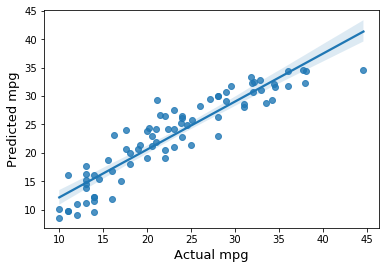

In [23]:
# regression plot y-pred vs y-actual (test)
res=pd.DataFrame()
res['prediction']=reg.predict(X_test)
res['actual']=y_test.values
ax=sns.regplot(data=res,x="actual",y="prediction")
ax.set_xlabel("Actual mpg",fontsize=13)
ax.set_ylabel("Predicted mpg",fontsize=13)
plt.show()

<br>
<p style="font-size: 16px;">
Wow, so see! By adjusting for VIF and removing the highly collinear features from the training data, we were able to increase the accuracy using the best hyperparameter configuration from gridsearch, by nearly 4%!
</p>
<br>
<p style="font-size: 16px;">
We went from 81% originally to now roughly 85% accuracy!<br>
</p>
<br>